<h1><center> Fast Multidimensional Signal Processing with Shearlab.jl </h1><center>
<center><b> Héctor Andrade Loarca </b> </center>
<center><b> TU Berlin, BMS </b> </center> 
<img src="../Beamer/images/logo-julia.png" alt="Mountain View" style="width:300px;height:114px;">


<center> <h3> Fourier Transform. </h3></center>

In [1]:
using PyPlot

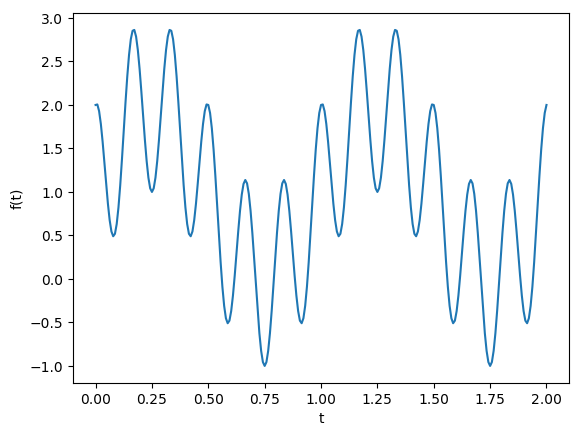

PyObject <matplotlib.text.Text object at 0x329f0f550>

In [2]:
# Create and plot signal
t=0:2/256:2;
f=sin(2*pi*t)+2*(cos(6*pi*t)).^2;
plot(t,f)
xlabel("t")
ylabel("f(t)")

In [4]:
# Compute fast fourier transform
@time F = fft(f);

  0.000318 seconds (77 allocations: 12.281 KB)


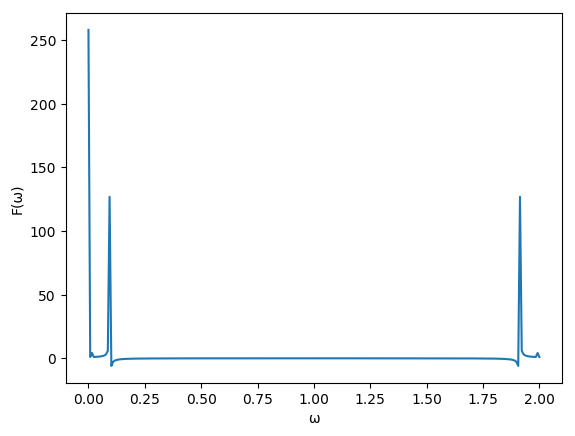

/Users/hector/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


PyObject <matplotlib.text.Text object at 0x329fc8b10>

In [5]:
plot(t,F)
xlabel("ω")
ylabel("F(ω)")

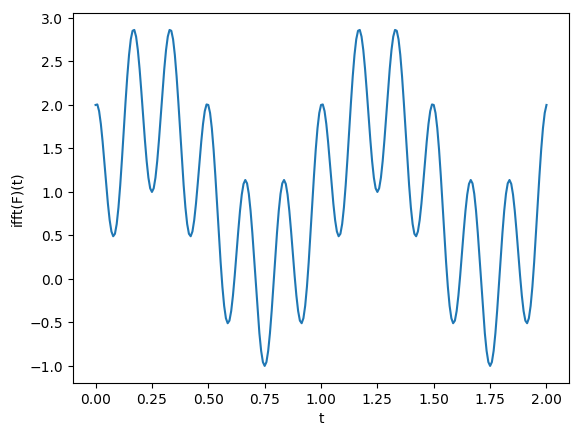

PyObject <matplotlib.text.Text object at 0x32a01d990>

In [6]:
plot(t,ifft(F))
xlabel("t")
ylabel("ifft(F)(t)")

<center> <h3> Wavelet Transform </h3> </center>

In [7]:
using Shearlab

The 2D wavelet transform

$$ d_j^k[n] =\langle f,\psi_{j,n}^k\rangle$$

for scales $ j \in \mathbb{Z}$, position $ n \in \mathbb{Z}^2 $ and orientation $ k \in \{H,V,D\} $.

And wavelet atoms defined by scaling and translating three mother
atoms $ \{\psi^H,\psi^V,\psi^D\} $:

$$ \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k\left(\frac{x-2^j n}{2^j}\right)$$

Defined by tensor product of a 1-D wavelet function $\psi(t)$ and a 1-D scaling function $\phi(t)$

$$ \psi^H(x)=\phi(x_1)\psi(x_2),  \text{ } \psi^V(x)=\psi(x_1)\phi(x_2)
\text{ and } \psi^D(x)=\psi(x_1)\psi(x_2).$$

Translated into high-pass and low-pass filters
$$ g[n] = \frac{1}{\sqrt{2}}\langle \psi(t/2),\phi(t-n)\rangle
\text{ and } h[n] = \frac{1}{\sqrt{2}}\langle\phi(t/2),\phi(t-n)\rangle. $$

<b> 1D </b>

Compute the low pass signal $a \in \mathbb{R}^{N/2}$ and the high pass signal $d \in \mathbb{R}^{N/2}$ as
$$ a = (f * h) \downarrow 2 \text{  and  }
d = (f * g) \downarrow 2$$
where the sub-sampling is defined as
$$ (u \downarrow 2)[k] = u[2k]. $$
where $g[n]=(-1)^{1-n}h[1-n]$.

When the filters are orthogonal transform the inverse will be
$$ (a \uparrow 2) * \tilde h + (d \uparrow 2) * \tilde g = f $$
where $\tilde h[n]=h[-n]$ (computed modulo $N$) and
$ (u \uparrow 2)[2n]=u[n] $ and  $ (u \uparrow 2)[2n+1]=0$.

#### 2D

One needs to perform filtering/downsampling in the different directions

$$  \tilde a_{j-1} = (a_j *^H h) \downarrow^{2,H} \text{  and  } \tilde d_{j-1} = (a_j *^H g) \downarrow^{2,H}.$$

Here, the operator $*^H$ and $\downarrow^{2,H}$ are defined by applying $*$ and $\downarrow^2$ to each column of the matrix.


$$a_{j-1} = (\tilde a_j *^V h) \downarrow^{2,V} \text{  and  } d_{j-1}^V = (\tilde a_j *^V g) \downarrow^{2,V},$$ 

$$ d_{j-1}^H = (\tilde d_j *^V h) \downarrow^{2,V} \text{  and  } d_{j-1}^D =(\tilde d_j *^V g) \downarrow^{2,V}.$$

In [8]:
# Pick Daubechie filter and its mirror
h = Shearlab.filt_gen(WT.db2)
g = Shearlab.mirror(h)

5-element Array{Float64,1}:
 -0.0     
 -0.12941 
 -0.224144
  0.836516
 -0.482963

In [9]:
# Read Data
n = 1024;
# The path of the image
name = "../../../data_samples/barbara.jpg";
f = Shearlab.load_image(name, n,n,1);

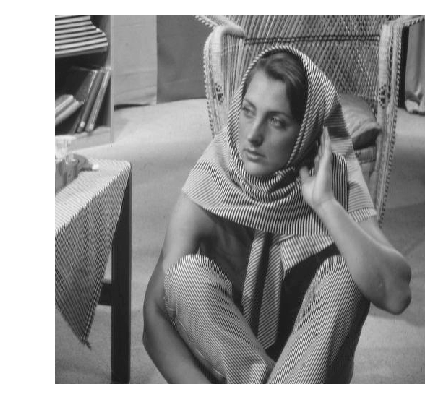

In [10]:
#Rescale image in [0,1] summing the 3 arrays in the RGB format
f = Shearlab.rescale(sum(f,3));
# Reduce one dimension 
f = f[:,:,1];
Shearlab.imageplot(f);

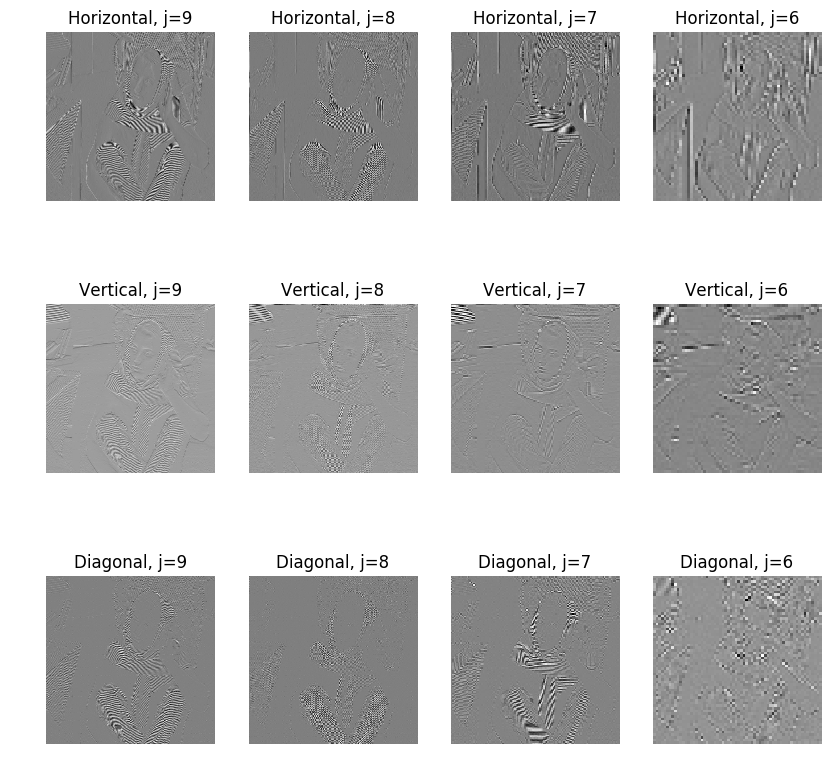

In [11]:
# Different scales
Jmax = round(Int64,log2(n))-1;
Jmin = 1;
fW = copy(f);
clf;
figure(figsize=(10,10));
for j=Jmax:-1:Jmin
    A = fW[1:2^(j+1),1:2^(j+1)];
    for d=1:2
        Coarse = Shearlab.subsampling(Shearlab.cconvol(A,h,d),d);
        Detail = Shearlab.subsampling(Shearlab.cconvol(A,g,d),d);
        A = cat(d, Coarse, Detail );
    end
    fW[1:2^(j+1),1:2^(j+1)] = A;
    j1 = Jmax-j;
    if j1<4
        Shearlab.imageplot(A[1:2^j,2^j+1:2^(j+1)], "Horizontal, j=$j", 3,4, j1 + 1);
        Shearlab.imageplot(A[2^j+1:2^(j+1),1:2^j], "Vertical, j=$j", 3,4, j1 + 5);
        Shearlab.imageplot(A[2^j+1:2^(j+1),2^j+1:2^(j+1)], "Diagonal, j=$j", 3,4, j1 + 9);
    end
end

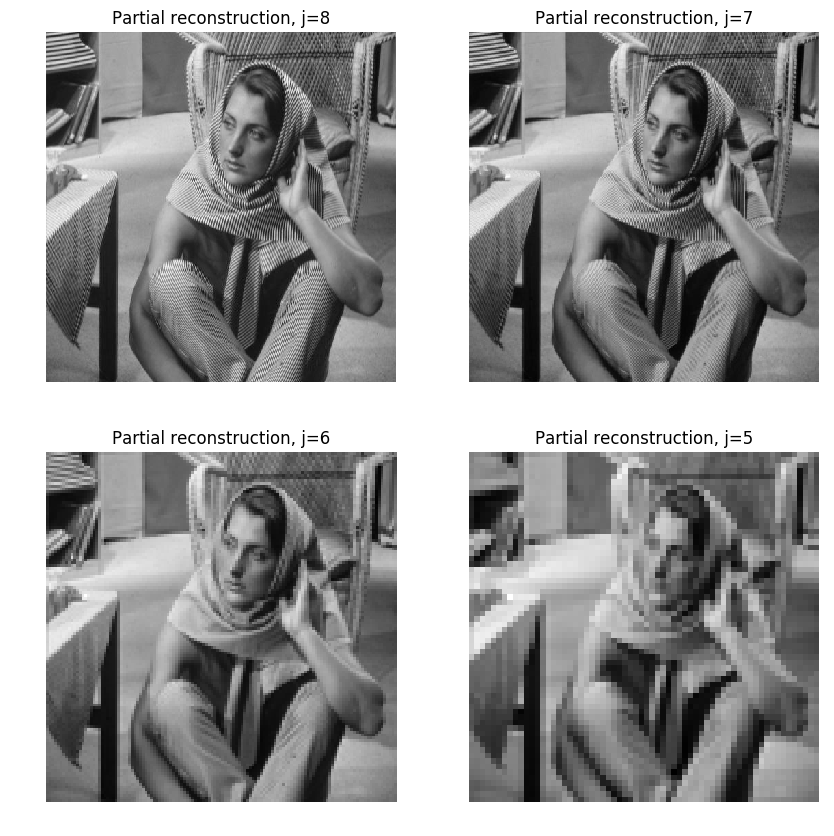

In [12]:
f1 = copy(fW);
clf;
figure(figsize=(10,10));
for j=Jmin:Jmax
    A = f1[1:2^(j+1),1:2^(j+1)];
    for d=1:2
        if d==1
            Coarse = A[1:2^j,:];
            Detail = A[2^j+1:2^(j+1),:];
        else
            Coarse = A[:,1:2^j];
            Detail = A[:,2^j+1:2^(j+1)];                
        end
        Coarse = Shearlab.cconvol(Shearlab.upsampling(Coarse,d),Shearlab.reverse(h),d);
        Detail = Shearlab.cconvol(Shearlab.upsampling(Detail,d),Shearlab.reverse(g),d);
        A = Coarse + Detail;
        j1 = Jmax-j;
        if j1>0 && j1<5
            Shearlab.imageplot(A, "Partial reconstruction, j=$j", 2,2,j1);
        end
    end
    f1[1:2^(j+1),1:2^(j+1)] = A;
end

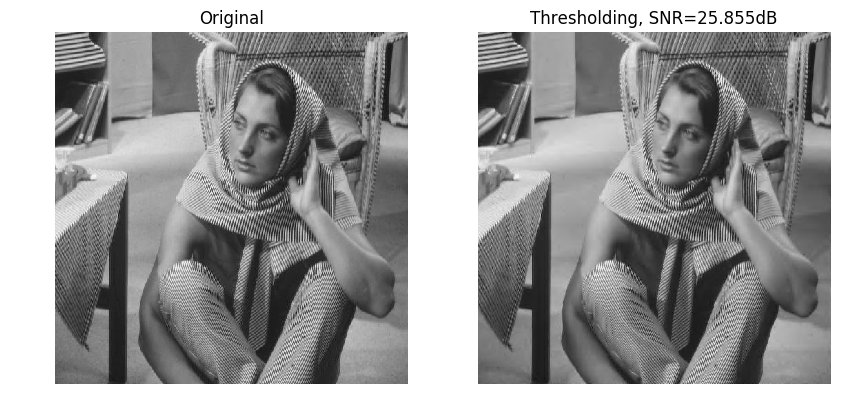

In [13]:
# number of kept coefficients
m = round(n^2/16); 
# compute the threshold T
Jmin = 1;
fW = Shearlab.perform_wavortho_transf(f,Jmin,+1, h); 
# select threshold
v = sort(abs.(fW[:])); 
if v[1]<v[n^2]
    v = Shearlab.reverse(v);
end
# inverse transform
T = v[Int(m)];
fWT = fW .* (abs.(fW).>T);2
# inverse
fnlin = Shearlab.perform_wavortho_transf(fWT,Jmin,-1, h);
# display
clf;
figure(figsize=(10,10));
u1 = @sprintf("Original");
u2 = @sprintf("Thresholding, SNR=%.3fdB", Shearlab.snr(f,fnlin)); 
Shearlab.imageplot(Shearlab.clamp(f),u1, 1,2,1 );
Shearlab.imageplot(Shearlab.clamp(fnlin),u2, 1,2,2 );

<center> <h3> Non-separable Shearlet Transform </h3> </center>

$$\text{DST}_{j,k,m}^{2D}(f) = \left(\overline{\psi^d_{j,k}}*f_J\right)\left(2^J A_{2^j}^{-1}M_{c_j}m\right) \text{ for } j=0,1,...,J-1 $$
with generating function
$$
\hat{\psi}(\xi)=P(\xi_1/2,\xi_2/2)\widehat{\psi_1\otimes \phi_1}(\xi)
$$
where 
$$
\psi^d_{j,k} = S^d_{k/2^{j/2}}(p_j*W_j)
$$
$A_{2^j}$ is the parabolic scaling matrix given by
$$ A_{2^j} = \left( \begin{matrix} 2^j & 0 \\ 0 & 2^{j/2} \end{matrix}\right) $$
and the Shearing transform is given by
$$ S_k = \left( \begin{matrix} 1 & k \\ 0 & 1 \end{matrix}\right)$$

The scaling and wavelet filters now in each scale are:
$$ 
\hat{h}_j(\xi_1)=\prod_{k=0}^{j-1}\hat{h}(2^k\xi_1) 
\text{    ,    }  
\hat{g}_j(\xi_1)=\hat{g}\left(\frac{2^j\xi_1}{2}\right) \hat{h}_{j-1}(\xi_1)
$$
and the directional filter transform 
$$p_j(\xi_1,\xi_2)=\widehat{P(2^{J-j-1}\xi_1,2^{J-j/2}\xi_2)} \Longrightarrow p_j*W_j=p_j*g_{J-j}\otimes h_{J-j}$$

The digital shearing to mantain the domain grid will be
$$
S_{k/2^{j/2}}(x)=\left(\left( x_{\uparrow 2^{j/2}}*_1h_{j/2}\right)(S_k\cdot)*_1\overline{h_{j/2}}\right)_{\downarrow 2^{j/2}}
$$
for $j\in\{0,J-1\}$ and $|k|\leq \lceil 2^{j/2}\rceil$.

In [14]:
# Read Data
n = 512;
# The path of the image
name = "../../../data_samples/barbara.jpg";
data_nopar = Shearlab.load_image(name, n);
data_par = Shearlab.load_image(name, n,n,1);

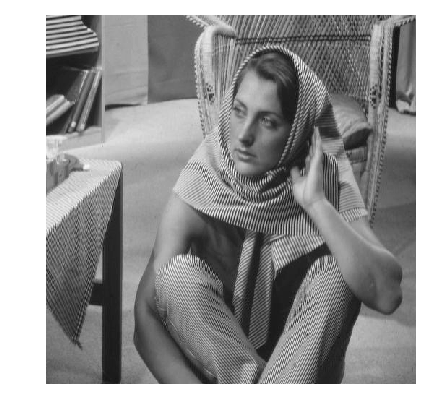

In [15]:
# Reduce one dimension 
data_nopar = data_nopar[:,:,1];
data_par = data_par[:,:,1]
Shearlab.imageplot(data_nopar);

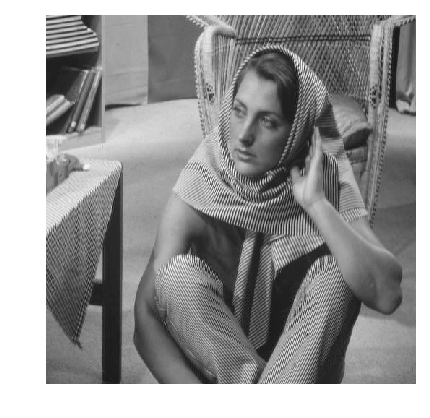

In [16]:
Shearlab.imageplot(data_par);

In [17]:
# Size of the images
sizeX_nopar = size(data_nopar,1);
sizeY_nopar = size(data_nopar,2);
sizeX_par = size(data_par,1);
sizeY_par = size(data_par,2);

In [18]:
# Set the variables for the Shearlet trasform
rows_nopar = sizeX_nopar;
cols_nopar = sizeY_nopar;
rows_par = sizeX_par;
cols_par = sizeY_par;
X_nopar = data_nopar; 
X_par = data_par; 

In [19]:
# No. of scales
nScales = 4;
shearLevels = ceil((1:nScales)/2)
scalingFilter = Shearlab.filt_gen("scaling_shearlet");
directionalFilter = Shearlab.filt_gen("directional_shearlet");
waveletFilter = Shearlab.mirror(scalingFilter);
scalingFilter2 = scalingFilter;
full = 0;

<center> <h3> Generation of Shearlet System </h3> </center>

In [23]:
# Compute the corresponding shearlet system without gpu
@time shearletSystem_nopar= Shearlab.getshearletsystem2D(rows_nopar,cols_nopar,4, shearLevels,full,
                                directionalFilter,
                                scalingFilter,0);

  9.081230 seconds (156.60 k allocations: 5.024 GB, 42.53% gc time)


In [24]:
using ArrayFire

In [25]:
# Compute the corresponding shearlet system without gpu
@time shearletSystem_par = Shearlab.getshearletsystem2D(rows_par,cols_par,nScales,shearLevels,full,
                                directionalFilter,
                                scalingFilter,1);

  2.392219 seconds (173.99 k allocations: 506.944 MB, 13.35% gc time)


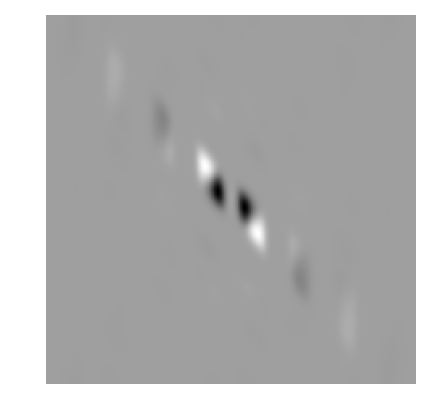

In [86]:
shearlet1 = Array(shearletSystem_nopar.shearlets[:,:,1]);
Shearlab.imageplot(real(shearlet1));

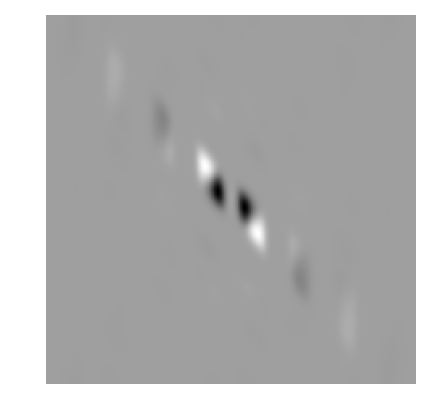

In [87]:
# Comparison with the generated by arrayfire
shearlet1 = Array(shearletSystem_par.shearlets[:,:,1]);
Shearlab.imageplot(real(shearlet1));

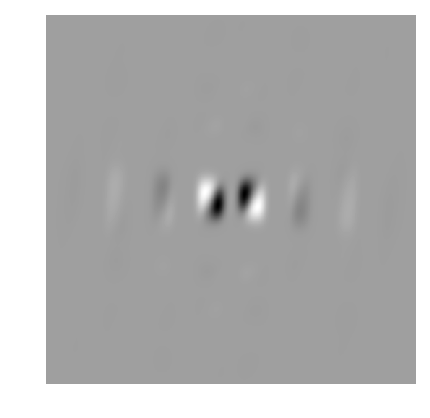

In [88]:
shearlet3 = Array(shearletSystem_nopar.shearlets[:,:,3]);
Shearlab.imageplot(real(shearlet3))

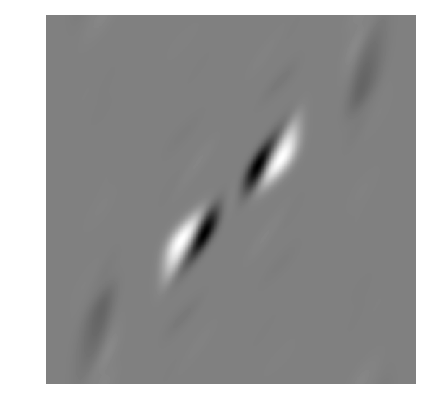

In [89]:
shearlet10 = Array(shearletSystem_nopar.shearlets[:,:,10]);
Shearlab.imageplot(real(shearlet10))

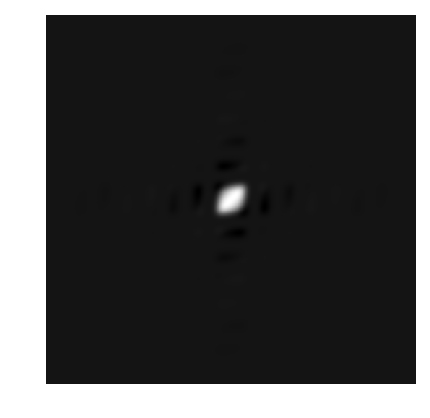

In [90]:
shearlet17 = Array(shearletSystem_nopar.shearlets[:,:,49]);
Shearlab.imageplot(real(shearlet17))

<center> <h3> Computation of shearlet coefficients </h3> </center>

In [201]:
# Compute the coefficients
@time coeffs_nopar = Shearlab.SLsheardec2D(X_nopar,shearletSystem_nopar);

  1.354317 seconds (7.12 k allocations: 1.354 GB, 27.04% gc time)


In [202]:
# Compute the coefficients in parallel
X_par = AFArray(convert(Array{Float32},X_par));
@time coeffs_par = Shearlab.SLsheardec2D(X_par,shearletSystem_par);

  0.141841 seconds (5.06 k allocations: 98.115 MB, 5.82% gc time)


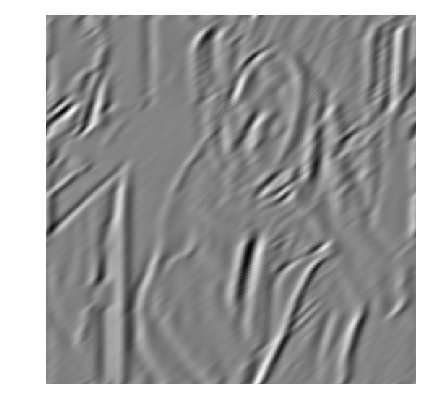

In [203]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,1])))

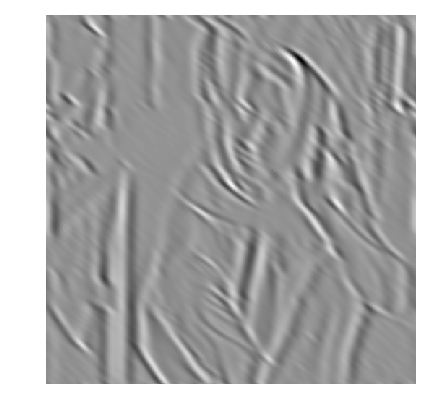

In [204]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,5])))

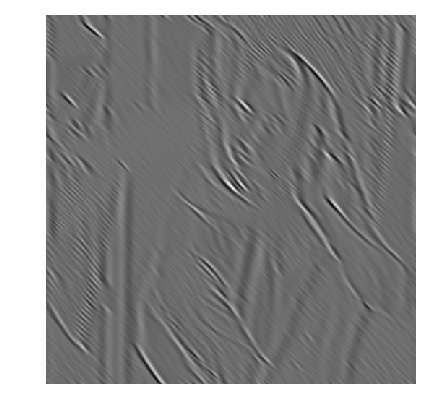

In [205]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,10])))

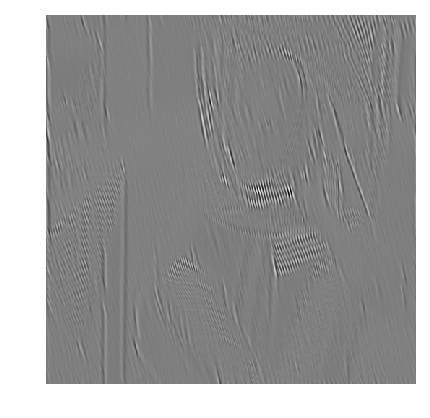

In [206]:
Shearlab.imageplot(real(Array(coeffs_nopar[:,:,16])))

<center> <h3> Reconstruction of the image with the shearlet system and coefficients </h3> </center>

In [207]:
# Make the recovery
@time Xrec_nopar=Shearlab.SLshearrec2D(coeffs_nopar,shearletSystem_nopar);

  1.080673 seconds (6.17 k allocations: 1.364 GB, 20.49% gc time)


In [208]:
# Make the recovery in parallel
@time Xrec_par=Shearlab.SLshearrec2D(coeffs_par,shearletSystem_par);

  0.017050 seconds (5.55 k allocations: 2.126 MB)


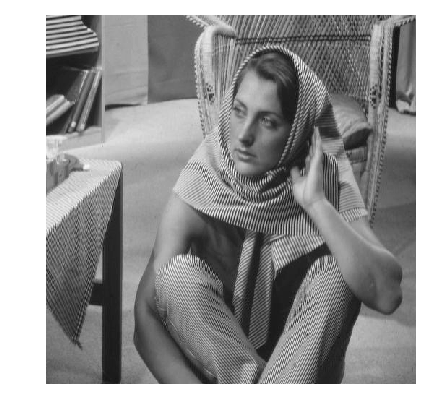

In [209]:
# The recovery is very good
Shearlab.imageplot(Array(Xrec_nopar));

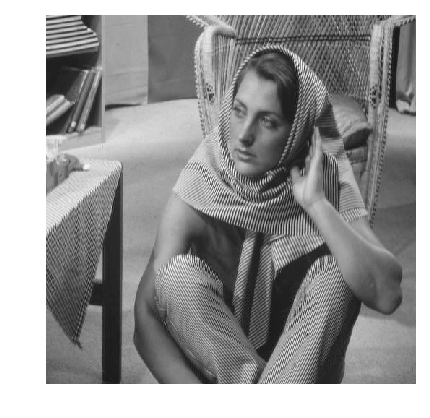

In [210]:
# The recovery is very good
Shearlab.imageplot(Array(Xrec_par));

<center> <h3> Benchmarks with matlab version </h3> </center>

- **2D version.**

| Benchmark     |    Matlab(seconds)     |    Julia no gpu(seconds)     |  Julia gpu (seconds)  | Improvement rate no gpu | Improvement rate gpu |
|:-------------:|:-------------:|:------------:|:----------------:|:------------------------:|:-----------------------:|
| Shearlet System 256x256| 1.06 | 0.61 | 0.31 | 1.73 |3.42 |
| Decoding 256x256 | 0.18 | 0.15 | 0.043 | 1.2 |4.19 |
| Reconstruction 256x256 | 0.18 | 0.12 | 0.018  | 1.5 |8.57 |
| Shearlet System 512x512 | 5.15 | 3.07 | 1.8 | 1.22 |2.08 |
| Decoding 512x512 | 0.96 | 0.87 | 0.09 | 1.10 |10.66 |
| Reconstruction 512x512 | 0.84 | 0.52 | 0.021 | 1.62 |14.00 |
| Shearlet System 1024x1024 | 35.84 | 15.65 | 2.44 | 2.29 |14.68|
| Decoding 1024x1024 | 4.70 | 4.67 | 0.40 | 1.01 | 8.54|
| Reconstruction 1024x1024 | 4.72 | 4.48 | 0.037 | 1.05 |127.56 |
| Shearlet System 2048x2048 | 196.69 | 68.43 | 5.4 | 2.87 | 36.42 |
| Decoding 2048x2048 | 108.19 | 32.50 | 5.88 | 3.33 | 18.39|
| Reconstruction 2048x2048 | 73.20 | 23.08 |4.23 | 97.6 | 23.09|


The benchmarks were made with 4 scales, in a Macbook pro with OSX 10.10.5, with 8GB memory, 2.7GHz Intel Core i5 processor and Graphic Card Intel Iris Graphics 6100 1536 MB.

- **Benchmarks plots 2D**.

<center><img src="Shearlet_system_benchmark.png" alt="system" style="width: 600px;"/><center/>

<center><img src="Shearlet_decoding_benchmark.png" alt="decoding" style="width: 600px;"/><center/>

<center><img src="Shearlet_reconstruction_benchmark.png" alt="reconstruction" style="width: 600px;"/><center/>


<center> <h3> Applications </h3> </center>

<center> <h3> Image Denoising </h3> </center>

Let $f\in \ell^2(\mathbb{Z}^2)$ and 
   $$f_{\text{noisy}}(i,j)=f(i,j)+e(i,j)$$
with noise $e(i,j)\sim \mathcal{N}(0,\sigma^2)$.  
Then
$$
f_{\text{denoised}}=S^*T_{\delta}S (f_{\text{noisy}})
$$
where $S$ is sparsifying transform (analysis operator of the shearlet system) and $T_{\delta}$ is the hard thersholding operator
$$
(T_{\delta}x)(n)=
\begin{cases}
x(n)\text{  if  }|x(n)|\geq\delta\\
0\text{  else.}
\end{cases}
$$

In [232]:
# settings
sigma = 20;
scales = 4;
thresholdingFactor = 3;

In [233]:
# Give noise to data
X_nopar = data_nopar;
Xnoisy_nopar = X_nopar + sigma*randn(size(X_nopar));

In [234]:
# Decomposition
@time coeffs_nopar = Shearlab.sheardec2D( Xnoisy_nopar, shearletSystem_nopar);

  1.335141 seconds (7.12 k allocations: 1.354 GB, 25.45% gc time)


In [235]:
# Thresholding
@time coeffs_nopar = coeffs_nopar.*(abs.(coeffs_nopar).> thresholdingFactor*reshape(repmat(shearletSystem_nopar.RMS',size(X_nopar,1)*size(X_nopar,2), 1),
        size(X_nopar,1),size(X_nopar,2),length(shearletSystem_nopar.RMS))*sigma);

  0.725157 seconds (533.75 k allocations: 606.016 MB, 25.61% gc time)


In [236]:
# Reconstruction
Xrec_nopar = Shearlab.shearrec2D(coeffs_nopar, shearletSystem_nopar);

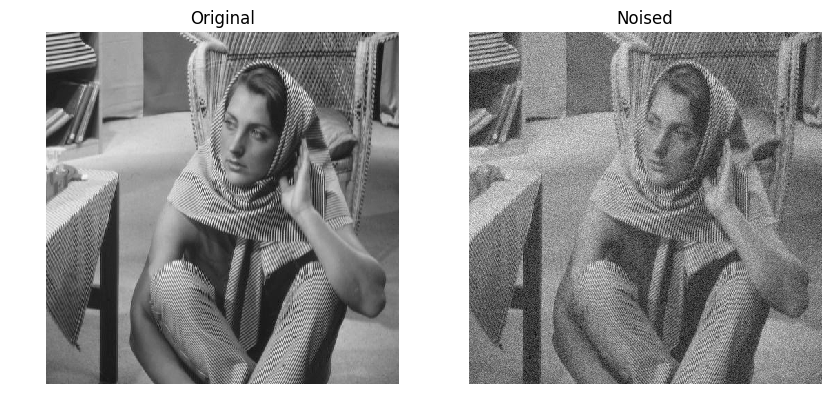

In [237]:
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(Array(X_nopar), "Original", 1,2,1); 
Shearlab.imageplot(Array(Xnoisy_nopar), "Noised", 1,2,2); 

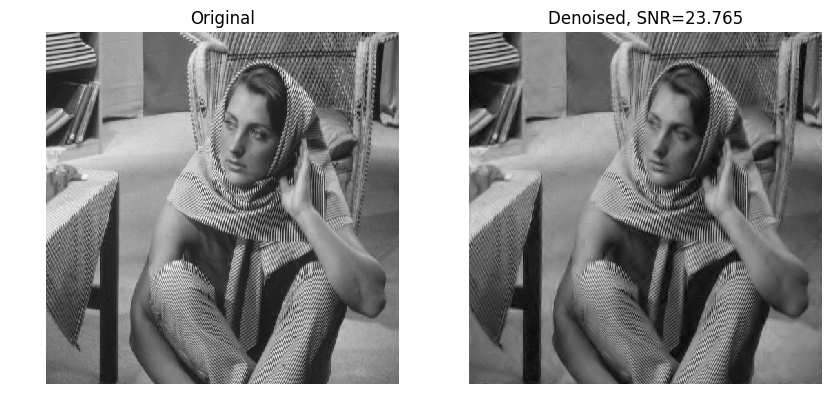

In [238]:
elin = Shearlab.snr(Array(X_nopar),Array(Xrec_nopar));
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(Array(X_nopar), "Original", 1,2,1); 
u = @sprintf("Denoised, SNR=%.3f", elin);
Shearlab.imageplot(real(Array(Xrec_nopar)), u, 1,2,2);

<center> <h3> Image inpainting </h3> </center>


- Inpainting = optimization problem.

Let $x\in\ell^2(\mathbb{Z}^2)$ be a grayscale image partially occluded by a binary mask $\mathbf{M}\in\{0,1\}^{\mathbb{Z}\times\mathbb{Z}}$, i.e.
$$
y =\mathbf{M}x
$$
One can recover $x$ (inpaint) using an sparsifying transformation with the inverse problem
$$
y^*=\min_{x\in \mathbb{R}^{N\times N}} ||S(x)||_1 \text{  s.t. } y=\mathbf{M}x
$$
By iterative thresholding algorithm
$$
x_{n+1} = S^*(T_{\lambda_n}(S(x_n+\alpha_n(y-\mathbf{M}x_n))))
$$

$\lambda_n$ decreases with the iteration number lineraly in $[\lambda_{min},\lambda_{max}]$. 

In [239]:
function inpaint2D(imgMasked,mask,iterations,stopFactor,shearletsystem)
    coeffs = Shearlab.sheardec2D(imgMasked,shearletsystem);
    coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
    for i in 1:shearletsystem.nShearlets
        coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
    end
    delta = maximum(abs.(coeffsNormalized[:]));
    lambda=(stopFactor)^(1/(iterations-1));
    imgInpainted = zeros(size(imgMasked));
    #iterative thresholding
    for it = 1:iterations
        res = mask.*(imgMasked-imgInpainted);
        coeffs = Shearlab.sheardec2D(imgInpainted+res,shearletsystem);
        coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
        for i in 1:shearletsystem.nShearlets
            coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
        end
        coeffs = coeffs.*(abs.(coeffsNormalized).>delta);
        imgInpainted = Shearlab.shearrec2D(coeffs,shearletsystem);  
        delta=delta*lambda;  
    end
    imgInpainted
end

inpaint2D (generic function with 1 method)

In [240]:
# Rename images
img_nopar = data_nopar
img_par = data_par;

In [241]:
# Import two masks
name = "../../../data_samples/data_inpainting_2d/mask_rand.png";
mask_rand = Shearlab.load_image(name, n);
mask_rand = mask_rand[:,:,1];
name = "../../../data_samples/data_inpainting_2d/mask_squares.png";
mask_squares = Shearlab.load_image(name, n);
mask_squares = mask_squares[:,:,1];

In [242]:
# Setting of data 
imgMasked_rand_nopar = img_nopar.*mask_rand;
imgMasked_rand_par = AFArray(convert(Array{Float32},img_par.*mask_rand));
imgMasked_squares_nopar = img_nopar.*mask_squares;
imgMasked_squares_par = AFArray(convert(Array{Float32},img_par.*mask_squares));
stopFactor = 0.005; # The highest coefficient times stopFactor
sizeX = size(imgMasked_rand_par,1);
sizeY = size(imgMasked_rand_par,2);
nScales = 4;
shearLevels = [1, 1, 2, 2];

In [243]:
tic()
imginpainted_rand50_nopar = inpaint2D(imgMasked_rand_nopar,mask_rand,50,stopFactor,shearletSystem_nopar);
toc()

elapsed time: 171.290234458 seconds


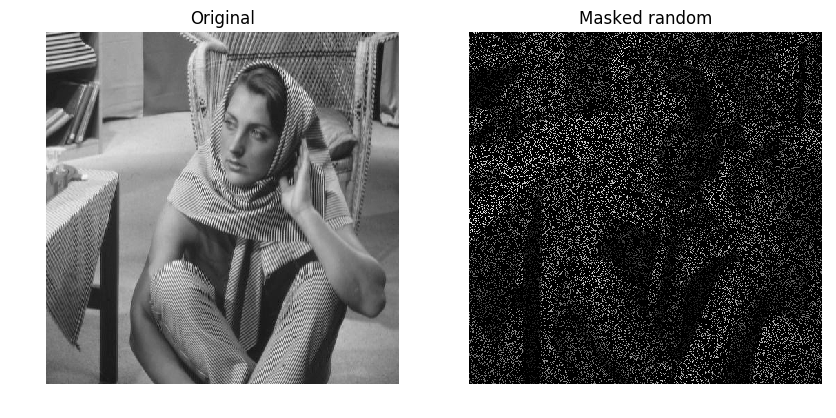

In [244]:
clf;
figure(figsize=(10,10));
Shearlab.imageplot(img_nopar, "Original", 1,2,1); 
Shearlab.imageplot(imgMasked_rand_nopar, "Masked random", 1,2,2); 

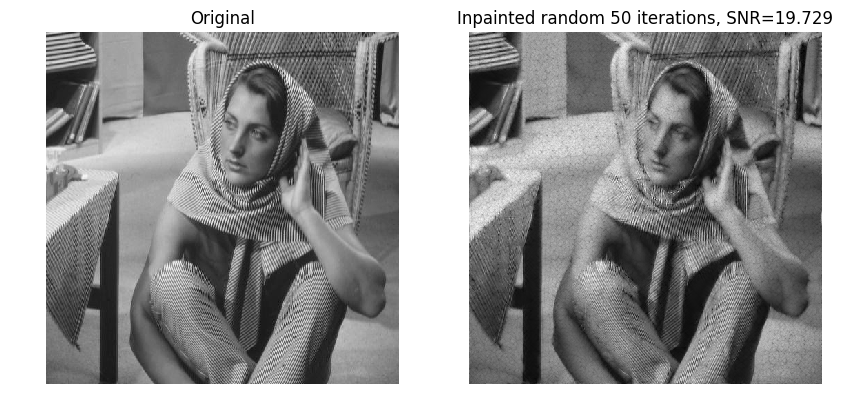

In [245]:
elin = Shearlab.snr(img_nopar,imginpainted_rand50_nopar);
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(img_nopar, "Original", 1,2,1); 
u = @sprintf("Inpainted random 50 iterations, SNR=%.3f", elin);
Shearlab.imageplot(real(imginpainted_rand50_nopar), u, 1,2,2);

In [246]:
tic()
imginpainted_squares50_nopar = inpaint2D(imgMasked_squares_nopar,mask_squares,50,stopFactor,shearletSystem_nopar);
toc()

elapsed time: 156.066344538 seconds


156.066344538

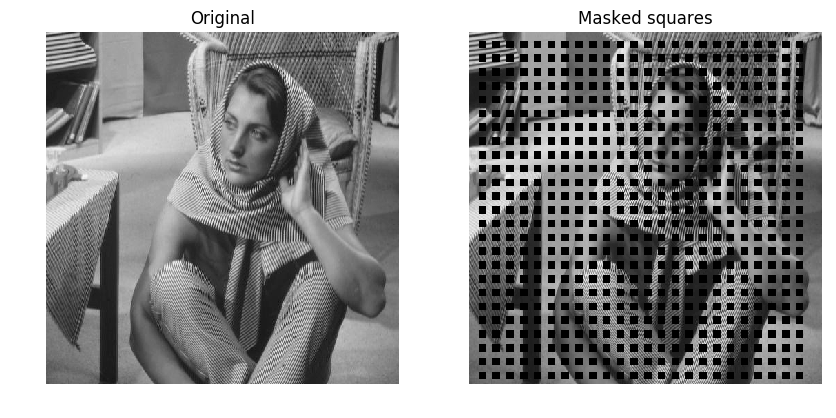

In [247]:
clf;
figure(figsize=(10,10));
Shearlab.imageplot(img_nopar, "Original", 1,2,1); 
Shearlab.imageplot(imgMasked_squares_nopar, "Masked squares", 1,2,2); 

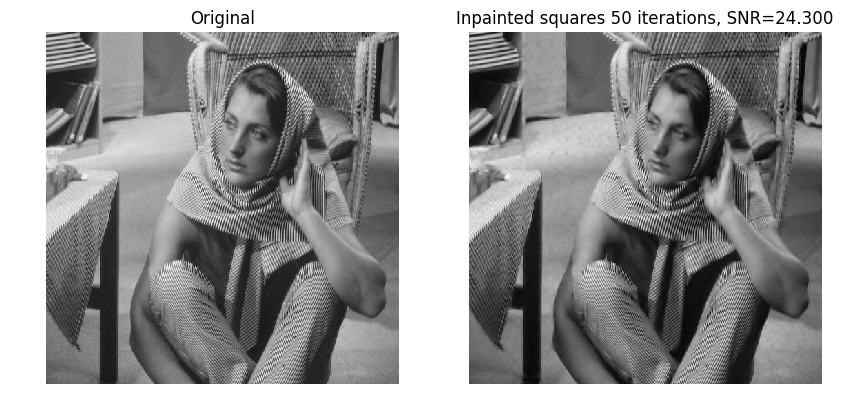

In [248]:
elin = Shearlab.snr(img_nopar,imginpainted_squares50_nopar);
# display
clf;
figure(figsize=(10,10));
Shearlab.imageplot(img_nopar, "Original", 1,2,1); 
u = @sprintf("Inpainted squares 50 iterations, SNR=%.3f", elin);
Shearlab.imageplot(real(imginpainted_squares50_nopar), u, 1,2,2);